## Purpose
The purpose of this notebook to train a K-Means clustering algorithm to classify paralyzed vs non-paralyzed vocal cords from ultrasound images.<br>

0 - not paralyzed
1 - paralyzed

This cell contains the imports needed for the program.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm
import csv
from IPython.display import clear_output
import matplotlib.pyplot as plt

This cell creates a folder to save the models.

In [2]:
try:
    if not os.path.exists('models'):
        os.makedirs('models')
except OSError:
    print('Error creating data directory.')

Image filename meanings:
- Healthy - regular healthy images of vocal cords
- Healthy2 - split in half, and blended back together images of healthy vocal cords, hopefully helps alleviate a potential mdodel issue with artifacts in the synthetic images.
- Leftpar - synthetic image, with the left side of the image stretched 50% vertically, right side is original image. 
- Rightpar - synthetic image, with the right side of the image stretched 50% vertically, left side is original image.

Defining a dataset class for our specific images.

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir  # Store image directory path
        self.transform = transform

        # List all image files in the directory
        self.img_labels = []
        print(f"Looking in directory: {img_dir}")

        # Check if directory exists
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Directory {img_dir} not found")

        for file_name in os.listdir(img_dir):
            # Debugging: print file names to see what's being processed
            print(f"Found file: {file_name}")
            
            # Check if it's a .png file
            if file_name.endswith('.png'):  
                label = None
                if 'healthy' in file_name.lower():
                    label = 0  # Healthy
                elif 'healthy2' in file_name.lower():
                    label = 0  # Healthy (modified)
                elif 'leftpar' in file_name.lower():
                    label = 1  # Left vocal cord paralysis
                elif 'rightpar' in file_name.lower():
                    label = 1  # Right vocal cord paralysis

                if label is not None:
                    self.img_labels.append((file_name, label))
                else:
                    print(f"Skipping unknown file: {file_name}")
                
        # Debugging: print number of labels found
        print(f"Found {len(self.img_labels)} .png files in the directory")

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0])
        image = Image.open(img_path)  # Load the .png file using PIL
        
        if self.transform:
            image = self.transform(image)
        
        label = self.img_labels[idx][1]  # Extract label (0 for healthy, 1 for paralysis)
        file_name = self.img_labels[idx][0]  # Extract file name
        
        return image, label, file_name

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Test the CustomDataset class
img_dir = '/data/ai_club/team_13_2024-25/VIPR/Data/ROI_cropped_images'

# Create dataset
data_set = CustomDataset(img_dir=img_dir, transform=transform)

Split the data and create dataloaders.

In [ ]:
from torch.utils.data import DataLoader, random_split
# Split the dataset into train and validation sets (80%-20% split)
train_size = int(0.8 * len(data_set))
val_size = len(data_set) - train_size
train_dataset, val_dataset = random_split(data_set, [train_size, val_size])

# Create DataLoader for train and validation sets
batch_size = 32  # You can adjust this batch size according to your needs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Setting up the model.

In [7]:
# Model, loss, and optimizer setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
model.aux_logits = False
model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for binary classification
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
val_accuracies = []
train_accuracies = []

In [9]:
import torch
import torch.nn as nn
from tqdm import tqdm

num_epochs = 5
model.train()

# Lists to store metrics for each epoch
epoch_data_train = []
epoch_data_val = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # TRAINING PHASE
    total_loss_train = 0
    total_correct_train = 0
    total_examples_train = 0
    batch_count = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} - TRAIN", unit="batch")
    for batch_idx, (inputs, labels, _) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.logits if hasattr(outputs, 'logits') else outputs  # For InceptionV3

        loss_train = criterion(outputs.squeeze(), labels.float().squeeze())
        loss_train.backward()
        optimizer.step()

        total_loss_train += loss_train.item()
        predictions = torch.round(torch.sigmoid(outputs))
        
        # Count correct predictions and total examples
        total_correct_train += (predictions.squeeze() == labels.squeeze()).sum().item()
        total_examples_train += labels.numel()
        batch_count += 1

    average_loss_train = total_loss_train / batch_count
    average_accuracy_train = total_correct_train / total_examples_train
    print(f"TRAINING | Loss: {average_loss_train:.4f}, Accuracy: {average_accuracy_train:.2%}")
    epoch_data_train.append([epoch+1, average_loss_train, average_accuracy_train])
    train_accuracies.append(average_accuracy_train)
    
    # VALIDATION PHASE
    model.eval()
    total_loss_val = 0
    total_correct_val = 0
    total_examples_val = 0
    batch_count = 0
    
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc="VAL", unit="batch")
    for batch_idx, (inputs, labels, _) in progress_bar_val:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        outputs = outputs.logits if hasattr(outputs, 'logits') else outputs

        loss_val = criterion(outputs.squeeze(), labels.float().squeeze())
        total_loss_val += loss_val.item()
        
        predictions_val = torch.round(torch.sigmoid(outputs))
        total_correct_val += (predictions_val.squeeze() == labels.squeeze()).sum().item()
        total_examples_val += labels.numel()
        batch_count += 1
        
    average_loss_val = total_loss_val / batch_count
    average_accuracy_val = total_correct_val / total_examples_val
    print(f"VALIDATION | Loss: {average_loss_val:.4f}, Accuracy: {average_accuracy_val:.2%}")
    epoch_data_val.append([epoch+1, average_loss_val, average_accuracy_val])
    val_accuracies.append(average_accuracy_val)
    
    # Optionally save model checkpoint here
    torch.save(model.state_dict(), f'models/InceptionV3-{epoch+1}-{average_loss_train:.4f}.pth')
    
    # Switch back to train mode for next epoch
    model.train()


Epoch 1/5


Epoch 1 - TRAIN: 100%|██████████| 103/103 [00:56<00:00,  1.82batch/s]


TRAINING | Loss: 0.3235, Accuracy: 85.04%


VAL: 100%|██████████| 26/26 [00:06<00:00,  3.92batch/s]


VALIDATION | Loss: 0.4966, Accuracy: 83.66%
Epoch 2/5


Epoch 2 - TRAIN: 100%|██████████| 103/103 [00:56<00:00,  1.83batch/s]


TRAINING | Loss: 0.1024, Accuracy: 96.21%


VAL: 100%|██████████| 26/26 [00:06<00:00,  3.89batch/s]


VALIDATION | Loss: 0.2202, Accuracy: 95.24%
Epoch 3/5


Epoch 3 - TRAIN: 100%|██████████| 103/103 [00:56<00:00,  1.83batch/s]


TRAINING | Loss: 0.0830, Accuracy: 96.86%


VAL: 100%|██████████| 26/26 [00:06<00:00,  3.89batch/s]


VALIDATION | Loss: 0.1870, Accuracy: 91.59%
Epoch 4/5


Epoch 4 - TRAIN: 100%|██████████| 103/103 [00:56<00:00,  1.82batch/s]


TRAINING | Loss: 0.0935, Accuracy: 96.55%


VAL: 100%|██████████| 26/26 [00:06<00:00,  3.89batch/s]


VALIDATION | Loss: 0.2266, Accuracy: 91.34%
Epoch 5/5


Epoch 5 - TRAIN: 100%|██████████| 103/103 [00:56<00:00,  1.82batch/s]


TRAINING | Loss: 0.0530, Accuracy: 97.99%


VAL: 100%|██████████| 26/26 [00:06<00:00,  3.90batch/s]


VALIDATION | Loss: 0.0226, Accuracy: 99.39%


In [10]:
print(train_accuracies)
print(val_accuracies)
print(num_epochs)
num_epochs_list = []
for i in range(num_epochs):
    num_epochs_list.append(i + 1)

[0.8504273504273504, 0.9621489621489622, 0.9685592185592186, 0.9655067155067155, 0.9798534798534798]
[0.8365853658536585, 0.9524390243902439, 0.9158536585365854, 0.9134146341463415, 0.9939024390243902]
5


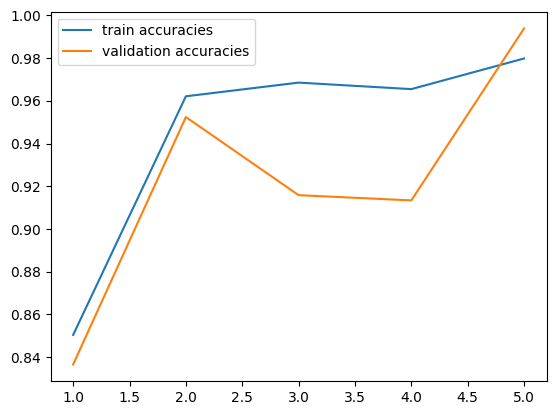

In [11]:

plt.plot(num_epochs_list, train_accuracies, label = 'train accuracies')
plt.plot(num_epochs_list, val_accuracies, label = 'validation accuracies')
plt.legend()
plt.show()

## Test that it works with a paralyzed image. Should return 1

In [12]:
# from PIL import Image
# import torch
# from torchvision import transforms

# # Load the model and weights
# model.load_state_dict(torch.load('models/InceptionV3-5-0.0614.pth'))
# model.eval()  # Switch to evaluation mode

# # Define the necessary transformations
# transform = transforms.Compose([
#     transforms.Resize((299, 299)),  # Resize to the required input size for InceptionV3
#     transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels (RGB)
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as InceptionV3 expects
# ])

# # Load the image
# image_path = "/data/ai_club/team_13_2024-25/VIPR/Data/ROI_cropped_images/rightpar_8173.wmv_frame1100.png"  # Replace with your image path
# image = Image.open(image_path)

# # Apply the transformations
# image = transform(image).unsqueeze(0)  # Add a batch dimension (since the model expects a batch of images)

# # Move the image to the same device as the model (GPU or CPU)
# image = image.to(device)

# # Make predictions
# with torch.no_grad():  # Disable gradient calculation for inference
#     outputs = model(image)
#     outputs = outputs.logits if hasattr(outputs, 'logits') else outputs  # InceptionV3 output adjustment
    
#     # Apply sigmoid to get probabilities, then round to get binary output (0 or 1)
#     prediction = torch.round(torch.sigmoid(outputs))

# # Print the predicted label
# print(f"Predicted label: {prediction.item()}")  # 0 or 1 based on your binary classification
